### Imports

In [2]:
import os
import csv
import faiss

# from .api_classes
from fr_functions         import *
from api_functions        import API_DIR, DST_ROOT_DIR, RAW_DIR,\
                                 GALLERY_DIR, TARGETS_DIR, RDB_DIR, detect_faces
from api_classes          import Representation, FRMatch
from utility_functions    import create_dir, get_image_paths

import numpy              as np
import matplotlib.pyplot  as plt
import matplotlib.image   as mpimg

from tqdm                 import tqdm
from uuid                 import uuid4
from deepface.commons     import functions, distance as dst

In [3]:
# All detectors and verifiers
DETECTOR_NAMES = ('opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface')
VERIFIER_NAMES = ('VGG-Face', 'OpenFace', 'Facenet', 'Facenet512', 'DeepFace', 'DeepID', 'Dlib', 'ArcFace', 'Emotion', 'Age', 'Gender', 'Race')

# Printing path variables
print('API_DIR:'.ljust(16), API_DIR)
print('DST_ROOT_DIR:'.ljust(16), DST_ROOT_DIR)
print('RAW_DIR:'.ljust(16), RAW_DIR)
print('GALLERY_DIR:'.ljust(16), GALLERY_DIR)
print('TARGETS_DIR:'.ljust(16), TARGETS_DIR)
print('RDB_DIR:'.ljust(16), RDB_DIR, '\n')

# Execute "on api / app startup"
# Creates all the required directories
for directory in [DST_ROOT_DIR, RAW_DIR, GALLERY_DIR, TARGETS_DIR, RDB_DIR]:
    print(f'Creating {directory} directory: ', end='')
    
    if create_dir(directory):
        print('directory exists. Continuing...')
    else:
        print('success.')


API_DIR:         /home/rpessoa/projects/loki/api
DST_ROOT_DIR:    /home/rpessoa/projects/loki/api/data
RAW_DIR:         /home/rpessoa/projects/loki/api/data/raw
GALLERY_DIR:     /home/rpessoa/projects/loki/api/data/gallery
TARGETS_DIR:     /home/rpessoa/projects/loki/api/data/targets
RDB_DIR:         /home/rpessoa/projects/loki/api/data/database 

Creating /home/rpessoa/projects/loki/api/data directory: directory exists. Continuing...
Creating /home/rpessoa/projects/loki/api/data/raw directory: directory exists. Continuing...
Creating /home/rpessoa/projects/loki/api/data/gallery directory: directory exists. Continuing...
Creating /home/rpessoa/projects/loki/api/data/targets directory: directory exists. Continuing...
Creating /home/rpessoa/projects/loki/api/data/database directory: directory exists. Continuing...


In [4]:
# Loading just the ArcFace model as this model will be used throughout this demo
models = load_face_verifier(['ArcFace'], save_dir='', show_prog_bar=False,
                            verbose=True)
print('\n', models)

Loading model ArcFace: 

2022-03-08 10:44:59.836470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rpessoa/miniconda3/envs/loki_env2/lib/python3.9/site-packages/cv2/../../lib64:
2022-03-08 10:44:59.836615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-08 10:44:59.836667: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DRS7KH1): /proc/driver/nvidia/version does not exist
2022-03-08 10:44:59.839399: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


success!

 {'ArcFace': <keras.engine.functional.Functional object at 0x7f00de571160>}


### Test Example

First, building a database using the images in the *'/data/raw'* directory.
Then, apply the same pipeline to verify the images in the *'/data/targets'* directory.

This is a step-by-step example.

In [12]:
# User selects 1 (or X) models. Let's start with 1 model for now:
chosen_model      = 'ArcFace'
chosen_backend    = 'retinaface'
align             = True
normalization     = 'base'
similarity_metric = 'cosine'
image_paths       = get_image_paths(RAW_DIR)
targets_paths     = get_image_paths(TARGETS_DIR)
image_tags        = ['Jennifer Aniston', 'Angelina Jolie', 'Angelina Jolie',
                     'Scarlett Johansson', 'Mark Zuckerberg', 'Elon Musk',
                     'Jeff Bezos', 'Sundar Pichai', 'Katy Perry']
db_path           =  RDB_DIR # no database exists

image_paths.sort()
targets_paths.sort()

# 0a. Loads all the models: this has been done before
# 0b. Loads representation database
rep_db   = load_representation_db(db_path, verbose=True) # this will be empty
n_images = len(image_paths)
print('')

# Let's do the whole pipeline for each image
for i, img_path, tag in zip(range(n_images), image_paths, image_tags):
    # Current iteration and image
    temp = img_path.split('/')[-1]
    print(f'Image {i}:', f'{tag}'.ljust(20), f'({temp})')

    # 1. Check if a representation exists for the current image in the database
    # rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now, no representation exists

    # Calculate the face image embedding
    region, embeddings = calc_embedding(img_path, models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)

    # Create a new representation
    new_rep = create_new_representation(img_path, region, embeddings, tag=tag)

    # Adds new representation to database
    rep_db.append(new_rep)

print('\n', '*'*100, '\n')

# Sort database
rep_db.sort(key=lambda x: x.image_name)
    
# - Print database summary
for i in range(len(rep_db)):
    print(f'UID: {rep_db[i].unique_id}',
          f'Tag: {rep_db[i].name_tag}'.ljust(25),
          f'Path: {rep_db[i].image_fp}', sep=' | ')

Opening database: failed! Reason: database does not exist.

Image 0: Jennifer Aniston     (img03.jpg)
Image 1: Angelina Jolie       (img05.jpg)
Image 2: Angelina Jolie       (img07.jpg)
Image 3: Scarlett Johansson   (img08.jpg)
Image 4: Mark Zuckerberg      (img15.jpg)
Image 5: Elon Musk            (img18.jpg)
Image 6: Jeff Bezos           (img21.jpg)
Image 7: Sundar Pichai        (img24.jpg)
Image 8: Katy Perry           (img26.jpg)

 **************************************************************************************************** 

UID: 1cb98589-e216-4b0f-a4b5-034f61d9ddc4 | Tag: Jennifer Aniston     | Path: /home/rpessoa/projects/loki/api/data/raw/img03.jpg
UID: 63c30bb9-22b6-4e59-8cd1-5f05e44699cd | Tag: Angelina Jolie       | Path: /home/rpessoa/projects/loki/api/data/raw/img05.jpg
UID: faed75e2-11e1-43d3-8e5e-55507c43d436 | Tag: Angelina Jolie       | Path: /home/rpessoa/projects/loki/api/data/raw/img07.jpg
UID: f5d34767-477b-480a-89ad-959654b988a6 | Tag: Scarlett Johansson   

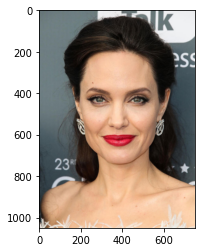


Target 0: img06.jpg    (verified: True  | name: Angelina Jolie)

Match 1:
Unique ID                : 63c30bb9-22b6-4e59-8cd1-5f05e44699cd
Name                     : Angelina Jolie
Image name               : img05.jpg
Image full path          : /home/rpessoa/projects/loki/api/data/raw/img05.jpg
Face region              : [91, 105, 185, 251]
Embeddings:
  > ArcFace: [-0.026780826970934868, 0.08662890642881393, 0.08762025088071823, ... , 0.23432829976081848](len=512)

Match 2:
Unique ID                : faed75e2-11e1-43d3-8e5e-55507c43d436
Name                     : Angelina Jolie
Image name               : img07.jpg
Image full path          : /home/rpessoa/projects/loki/api/data/raw/img07.jpg
Face region              : [405, 407, 579, 817]
Embeddings:
  > ArcFace: [-0.04091472551226616, 0.19594614207744598, 0.1693786084651947, ... , 0.23062342405319214](len=512)



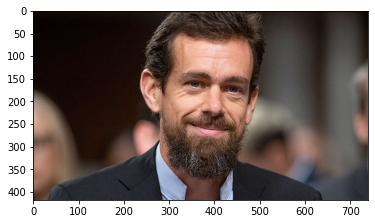


Target 4: img16.jpg    (verified: False | name: ---)



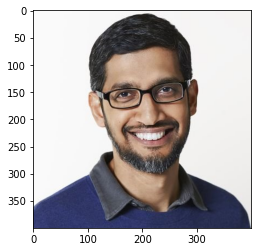


Target 7: img25.jpg    (verified: True  | name: Sundar Pichai)

Match 1:
Unique ID                : d2e974a9-0c96-4436-bd04-6a2820fdd733
Name                     : Sundar Pichai
Image name               : img24.jpg
Image full path          : /home/rpessoa/projects/loki/api/data/raw/img24.jpg
Face region              : [332, 193, 550, 747]
Embeddings:
  > ArcFace: [-0.034084782004356384, -0.10642530024051666, -0.12710878252983093, ... , -0.0674373134970665](len=512)



In [15]:
fr_results    = []
use_image_nos = [0, 4, 7]

# Let's do the whole pipeline for each image
for i, img_path in zip(range(len(targets_paths)), targets_paths):
    if not i in use_image_nos:
        continue

    # Check if a representation exists for the current image in the database
    # rep, idx = find_image_in_db(img_path, rep_db, shortcut=None) # for now, no representation exists
    plt.imshow(mpimg.imread(img_path))
    plt.show()

    # Calculate the face image embedding
    region, embeddings = calc_embedding(img_path, models, align=align,
                                            detector_name=chosen_backend, 
                                            verifier_names=chosen_model,
                                            normalization=normalization)

    # Calculates the embedding of the current image and gets all embeddings
    # (relevant to this model) from the database
    cur_emb     = embeddings[chosen_model]
    dtb_embs    = get_embeddings_as_array(rep_db, chosen_model)

    # Calculates the similarity between the current embedding and all embeddings
    # from the database
    match_obj   = calc_similarity(cur_emb, dtb_embs, metric=similarity_metric,
                                  model_name=chosen_model, threshold=-1)

    # Gets all matches
    matches = [rep_db[i] for i in match_obj['idxs']]
    
    # Prints current iteration, image information and verification result
    print('')
    print('Target {}: {}'.format(i, img_path.split('/')[-1]).ljust(22), end='')

    if len(matches) > 0:
        print(' (verified: True  | name: {})'.format(matches[0].name_tag))
    else:
        print(' (verified: False | name: ---)')

    print('')

    for j, match in enumerate(matches):
        print(f'Match {j+1}:')
        match.show_info()
        print('')